In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv("bank_data.csv")
data.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


In [4]:
data.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


In [5]:
data.isna().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

# Graphical EDA

In [6]:
customer_ages = data['age']
expected_recovery_amounts = data['expected_recovery_amount']

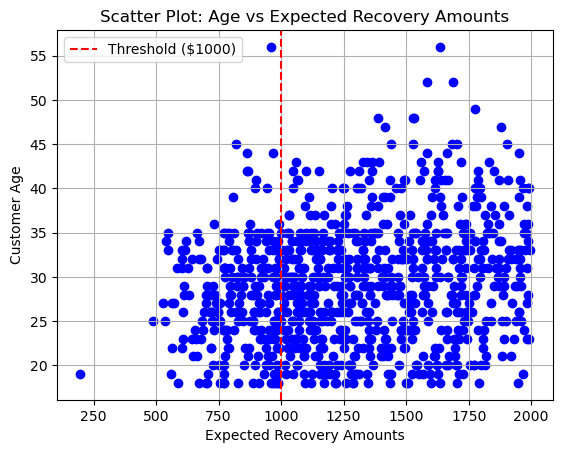

In [7]:
# Set the range for Level 0 and Level 1
lower_threshold = 0
upper_threshold = 2000

# Filter data within the range
filtered_ages = []
filtered_recovery_amounts = []
for Age, Amount in zip(customer_ages, expected_recovery_amounts):
    if lower_threshold < Amount <= upper_threshold:
        filtered_ages.append(Age)
        filtered_recovery_amounts.append(Amount)

# Create the scatter plot
plt.scatter(filtered_recovery_amounts, filtered_ages, color='blue')
plt.xlabel('Expected Recovery Amounts')
plt.ylabel('Customer Age')
plt.title('Scatter Plot: Age vs Expected Recovery Amounts')
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold ($1000)')
plt.legend()
plt.grid(True)
plt.show()


There is no any obvious jump(discontinuity) at the $1000 threshold.

# Statistical test: age vs. expected recovery amount 

In [8]:
from scipy import stats

In [9]:
threshold = 1000
start_range = 900
end_range = 1100

In [10]:
#create two groups : above and below the threshold
above_threshold = data[(data['expected_recovery_amount'] > threshold) & (data['expected_recovery_amount'] >= start_range) & (data['expected_recovery_amount'] <= end_range)]
below_threshold = data[(data['expected_recovery_amount'] <= threshold) & (data['expected_recovery_amount'] >= start_range) & (data['expected_recovery_amount'] <= end_range)]


In [11]:
#checking normality and equal variance
#perform shapiro-Wilk test for normality
_ , p_value_above = stats.shapiro(above_threshold['age'])
_ , p_value_below = stats.shapiro(below_threshold['age'])
alpha = 0.05    #significance level
if p_value_above > alpha and p_value_below > alpha:
    print("Both groups are normally distributed")
else:
    print("At least one group is not normally distributed")

At least one group is not normally distributed


The assumption of normallity is violated.Hrnce, we can't use t-test here.So we can go for Mann-Whitney U test

In [12]:
#perform Mann-Whitney U test
#Hypothesis:- 
#H0: There is no significant difference in the average age between customers just above and just below the $1000 Expected Recovery Amount threshold.
#H1: There is a significant difference in the average age between customers just above and just below the $1000 Expected Recovery Amount threshold.

statistic , p_value = stats.mannwhitneyu(above_threshold['age'], below_threshold['age'])

print("Mann-Whitney U statistic: ", statistic)
print("P-value: ", p_value)

Mann-Whitney U statistic:  4867.5
P-value:  0.07609109861196225


Here p_value > 0.05. So we fail to reject null hypothesis.That means there is no significant difference in the average age between customers just above and just below the threshold.

# Statistical test: sex vs. expected recovery amount 

In [13]:
from scipy.stats import chi2_contingency

#perform Chi-Squared test
#Hypothesis:-
#H0: there is no significant difference in the proportion of males below and above the $1000 threshold.
#H1: there is a significant difference in the proportion of males below and above the $1000 threshold.

# Create a contingency table
contingency_table = pd.crosstab(above_threshold['sex'], above_threshold['expected_recovery_amount'])

# Perform the Chi-squared test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi-squared value:", chi2)
print("P-value:", p_value)


Chi-squared value: 69.70265151515152
P-value: 0.18348523646072412


Here p_value > 0.05, so we fail to reject null hypothesis. That means there is no significant difference in the proportion of males below and above the $1000 threshold.

# Exploratory graphical analysis: recovery amount

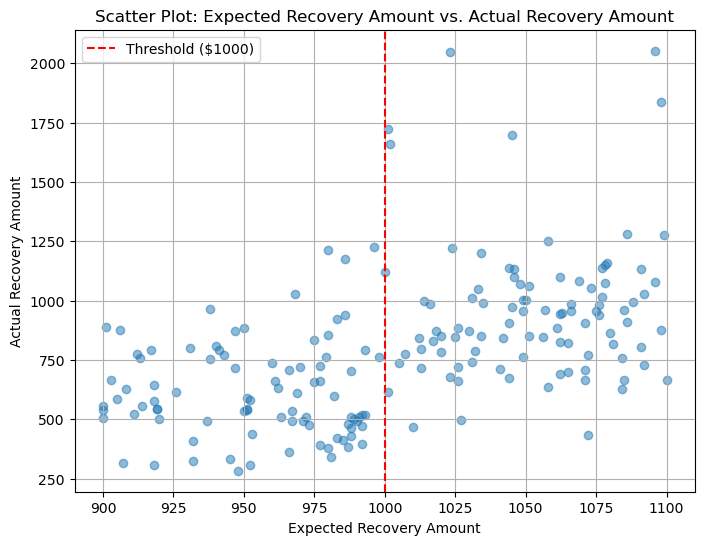

In [14]:
# Filter the data to include only Expected Recovery Amounts between $900 and $1100
data_filtered = data[(data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] <= 1100)]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_filtered['expected_recovery_amount'], data_filtered['actual_recovery_amount'], alpha=0.5)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Scatter Plot: Expected Recovery Amount vs. Actual Recovery Amount')

# Add a vertical line at the $1000 threshold to visualize the potential jump
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold ($1000)')

plt.legend()
plt.grid(True)
plt.show()


Here we can't see discontinuity at threshold $1000

# Statistical analysis: recovery amount

# Kruskal-Wallis test

In [15]:
from scipy.stats import kruskal

#Hypothesis:-
#H0: there is no significant difference in the distributions, suggesting a potential discontinuity above the $1000 threshold
#H1: there is a significant difference in the distributions, suggesting a potential discontinuity above the $1000 threshold

# Filter the data for the range $900 to $1100
Window1 = data[(data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] <= 1100)]

# Filter the data for the range $950 to $1050
Window2 = data[(data['expected_recovery_amount'] >= 950) & (data['expected_recovery_amount'] <= 1050)]

# Perform the Kruskal-Wallis test for each range
statistic_range_1, p_value_range_1 = kruskal(Window1['actual_recovery_amount'], Window1['expected_recovery_amount'])
statistic_range_2, p_value_range_2 = kruskal(Window2['actual_recovery_amount'], Window2['expected_recovery_amount'])

print("Kruskal-Wallis test results for range $900 to $1100:")
print("Statistic:", statistic_range_1)
print("P-value:", p_value_range_1)

print("\nKruskal-Wallis test results for range $950 to $1050:")
print("Statistic:", statistic_range_2)
print("P-value:", p_value_range_2)


Kruskal-Wallis test results for range $900 to $1100:
Statistic: 98.43345457373502
P-value: 3.361323971641858e-23

Kruskal-Wallis test results for range $950 to $1050:
Statistic: 56.821597680846416
P-value: 4.7719656724510236e-14


P-value for both range is greatre than 0.05, so we fail to reject the null hypothesis. Hence we say that, there is no significant difference in the distributions, suggesting no any potential discontinuity above the $1000 threshold

# Regression Modelling

# Model Without Threshold

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Separate the independent and dependent variables for the first model
X1 = data['expected_recovery_amount'].values.reshape(-1, 1)
y1 = data['actual_recovery_amount'].values

# Initialize and train the linear regression model
model1 = LinearRegression()
model1.fit(X1, y1)

predictions1 = model1.predict(X1)


# Get the coefficient and intercept of the first model
coef1 = model1.coef_[0]
intercept1 = model1.intercept_

r_squared1 = r2_score(y1, predictions1)
adjusted_r_squared1 = 1 - (1 - r_squared1) * (len(y1) - 1) / (len(y1) - X1.shape[1] - 1)


print("Model without threshold:")
print("Coefficient:", coef1)
print("Intercept:", intercept1)
print("R-squared:", r_squared1)
print("Adjusted R-squared:", adjusted_r_squared1)


Model without threshold:
Coefficient: 2.047657120990666
Intercept: -1650.4994474543869
R-squared: 0.8167224488168207
Adjusted R-squared: 0.8166249607576807


R-squared value indicates a stronger positive relationship between the actual and expected recovery amounts.

# Model With Threshold

In [17]:
# Create binary variable indicating above or below threshold
data['Above_threshold'] = (data['expected_recovery_amount'] > 1000).astype(int)

data_above_threshold = data[data['expected_recovery_amount'] > 1000]
data_below_threshold = data[data['expected_recovery_amount'] < 1000]


# Separate the independent and dependent variables for each side
X2_above = data_above_threshold['expected_recovery_amount'].values.reshape(-1, 1)
y2_above = data_above_threshold['actual_recovery_amount'].values

X2_below = data_below_threshold['expected_recovery_amount'].values.reshape(-1, 1)
y2_below = data_below_threshold['actual_recovery_amount'].values

# Initialize and train the linear regression models for each side
model2_above = LinearRegression()
model2_above.fit(X2_above, y2_above)

predictions2_above = model2_above.predict(X2_above)

model2_below = LinearRegression()
model2_below.fit(X2_below, y2_below)

predictions2_below = model2_below.predict(X2_below)

# Get the coefficients and intercepts for each side of the threshold
coef2_above = model2_above.coef_[0]
intercept2_above = model2_above.intercept_

r_squared2_above = r2_score(y2_above, predictions2_above)
adjusted_r_squared2_above = 1 - (1 - r_squared2_above) * (len(y2_above) - 1) / (len(y2_above) - X2_above.shape[1] - 1)

coef2_below = model2_below.coef_[0]
intercept2_below = model2_below.intercept_

r_squared2_below = r2_score(y2_below, predictions2_below)
adjusted_r_squared2_below = 1 - (1 - r_squared2_below) * (len(y2_below) - 1) / (len(y2_below) - X2_below.shape[1] - 1)

print("\nModel above threshold:")
print("Coefficient:", coef2_above)
print("Intercept:", intercept2_above)
print("R-squared:", r_squared2_above)
print("Adjusted R-squared:", adjusted_r_squared2_above)

print("\nModel below threshold:")
print("Coefficient:", coef2_below)
print("Intercept:", intercept2_below)
print("R-squared:", r_squared2_below)
print("Adjusted R-squared:", adjusted_r_squared2_below)



Model above threshold:
Coefficient: 2.0886304864181087
Intercept: -1848.291804811216
R-squared: 0.8017082964928774
Adjusted R-squared: 0.8015868686279006

Model below threshold:
Coefficient: 0.6692298149858131
Intercept: -33.295995433849384
R-squared: 0.19033321457383856
Adjusted R-squared: 0.18701490807619037


# Scatter Plot of Model Without Threshold

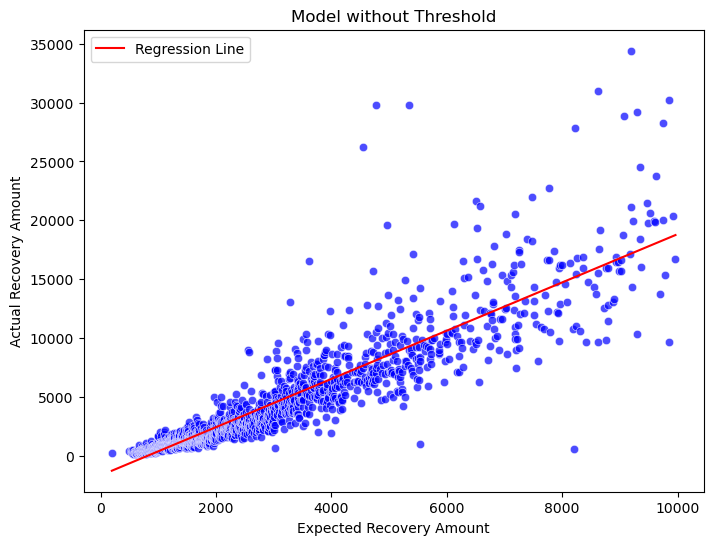

In [18]:
# Scatter plot with regression line for the first model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['expected_recovery_amount'], y=data['actual_recovery_amount'], color='blue', alpha=0.7)
plt.plot(data['expected_recovery_amount'], coef1 * data['expected_recovery_amount'] + intercept1, color='red', label='Regression Line')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Model without Threshold')
plt.legend()
plt.show()


# Scatter Plot of Model With Threshold

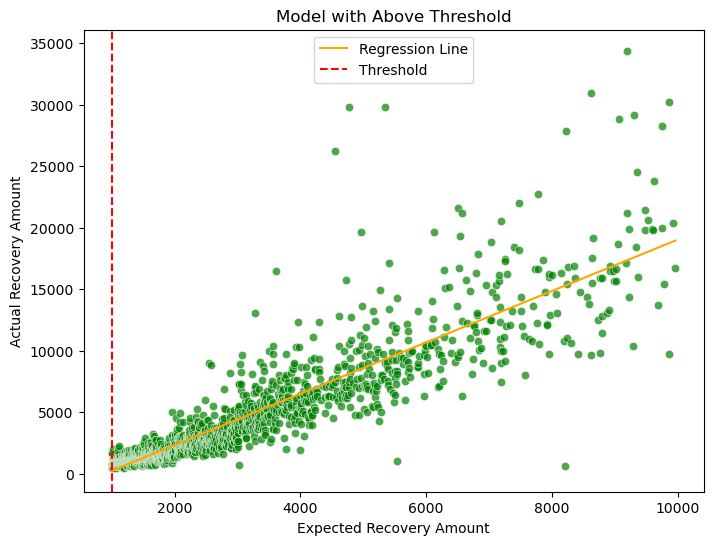

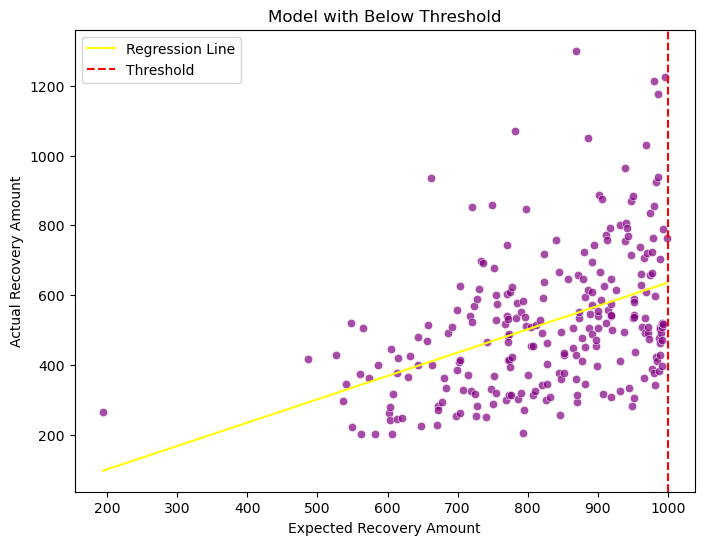

In [19]:
# Scatter plot with regression line for data above the threshold (Model with threshold)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_above_threshold['expected_recovery_amount'], y=data_above_threshold['actual_recovery_amount'], color='green', alpha=0.7)
plt.plot(data_above_threshold['expected_recovery_amount'], coef2_above * data_above_threshold['expected_recovery_amount'] + intercept2_above, color='orange', label='Regression Line')
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Model with Above Threshold')
plt.legend()
plt.show()

# Scatter plot with regression line for data below the threshold (Model with threshold)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_below_threshold['expected_recovery_amount'], y=data_below_threshold['actual_recovery_amount'], color='purple', alpha=0.7)
plt.plot(data_below_threshold['expected_recovery_amount'], coef2_below * data_below_threshold['expected_recovery_amount'] + intercept2_below, color='yellow', label='Regression Line')
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Model with Below Threshold')
plt.legend()
plt.show()


# Regression modeling: adjusting the window

In [20]:
import statsmodels.api as sm

# Select data points with an expected recovery amount between $950 and $1050
data_window = data[(data['expected_recovery_amount'] >= 950) & (data['expected_recovery_amount'] <= 1050)]

# Separate the independent and dependent variables for the second model with the new window
X2_window = data_window['expected_recovery_amount'].values.reshape(-1, 1)
y2_window = data_window['actual_recovery_amount'].values

# Fit the linear regression model for the second model with the new window
model2_window = sm.OLS(y2_window, sm.add_constant(X2_window)).fit()

# Print the summary of the new regression model
print(model2_window.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     30.64
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           2.60e-07
Time:                        16:55:20   Log-Likelihood:                -702.76
No. Observations:                 100   AIC:                             1410.
Df Residuals:                      98   BIC:                             1415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4365.0780    928.299     -4.702      0.0